In [4]:
import pybamm as pb

## PDE models
PDE models are more complex than ODE as they include derivatives with respect to 2 different variables. Additional steps, such as discretising the spatial domain, will be required.

Consider a problem about linear diffusion on a unit sphere:
$$ \frac{\partial c}{\partial t} = \nabla \cdot (\nabla c) $$

with the follwing boundary and initial conditions:

$$ \left. \frac{\partial c}{\partial r} \right \vert _{r = 0} = 0, \;\; \left. \frac{\delta c}{\delta r} \right \vert _{r=1} = 2, \;\; c \vert _{t=0} = 1 $$

As in the previous example, we start with a ```pybamm.BaseModel``` object and define our model variables. Since we are now solving a PDE we need to tell pybamm the domain each variable belongs to so that it can be discretised in space in the correct way. This is done by passing the keyword argument ```domain```, and in this example we choose the domain ```"negative particle"```. This argument is a string and we will later on define the geometry of the domain.

In [5]:
#initialise model
model = pb.BaseModel()
c = pb.Variable("Concentration", domain="negative particle")

# define governing equations
# defining intermediate quantities can also help
N = -pb.grad(c)         # flux
dcdt = -pb.div(N)       # rhs equation

model.rhs = {c: dcdt}   # adding equation to rhs

Setting the initial and boundary conditions of the PDE. 
- Note: 
    - Dirichlet = value of a function at a set of points. 
    - Neumann = gradient of the function at some set of points

These values can be any valid pybamm expressions.

In [6]:
# setting the initial conditions for the PDE model
model.initial_conditions = {c: pb.Scalar(1)}

#boundary conditions
lbc = pb.Scalar(0)
rbc = pb.Scalar(2)
model.boundary_conditions = {c: {"left": (lbc, "Neumann"), "right": (rbc, "Neumann")} }

# add variables to model
model.variables = {"Concentration": c, "Flux": N}

## Using the model

Now the model is now completely defined all that remains is to discretise and solve. Since this model is a PDE we need to define the geometry on which it will be solved, and choose how to mesh the geometry and discretise in space.

### Defining a geometry

We can define spatial variables in a similar way to how we defined model variables, providing a domain and a coordinate system. The relevent class to use here is ```pybamm.SpatialVariable```:

The domain needs to match the domain we have defined in our concentration variable, and the coordinate system can be chosen from ``` "cartesian"```, ```"cylindrical polar"``` and ```"spherical polar"```.

The geometry on which we wish to solve the model is defined using a nested dictionary. The first key is the domain name (here "negative particle") and the entry is a dictionary giving the limits of the domain.

### Defining mesh
We then create a uniform one-dimensional mesh with 20 points, using the ```pybamm.Mesh``` class. The mesh determines at which points of our spatial domain we will compute the solution. As well as the geometry, the mesh class also takes a dictionary of submesh types (see below, for more details), and a dictionary specifying the number of mesh points for each spatial variable.

Here we have used the ```pybamm.Uniform1DSubMesh``` class to create a uniform mesh. This class does not require any parameters, and so we can pass it directly to the submesh_types dictionary. However, many other submesh types can take additional parameters. Example of meshes that do require parameters include the ```pybamm.Exponential1DSubMesh``` which clusters points close to one or both boundaries using an exponential rule. It takes a parameter which sets how closely the points are clustered together, and also lets the users select the side on which more points should be clustered. For example, to create a mesh with more nodes clustered to the right (i.e. the surface in the particle problem), using a stretch factor of 2, we pass an instance of the exponential submesh class and a dictionary of parameters into the ```MeshGenerator``` class.

In [7]:
# define geometry
r = pb.SpatialVariable(
    "r", domain=["negative particle"], coord_sys="spherical polar"
)

geometry = {"negative particle": {r: {"min": pb.Scalar(0), "max": pb.Scalar(1)} } }

# mesh and discretise
submesh_types = {"negative particle": pb.Uniform1DSubMesh}
var_pts = {r: 20}
mesh = pb.Mesh(geometry, submesh_types, var_pts)

exp_mesh = pb.MeshGenerator(pb.Exponential1DSubMesh, submesh_params={"side": "right", "stretch": 2})

spatial_methods = {"negative particle": pb.FiniteVolume()}
disc = pb.Discretisation(mesh, spatial_methods)
disc.process_model(model)

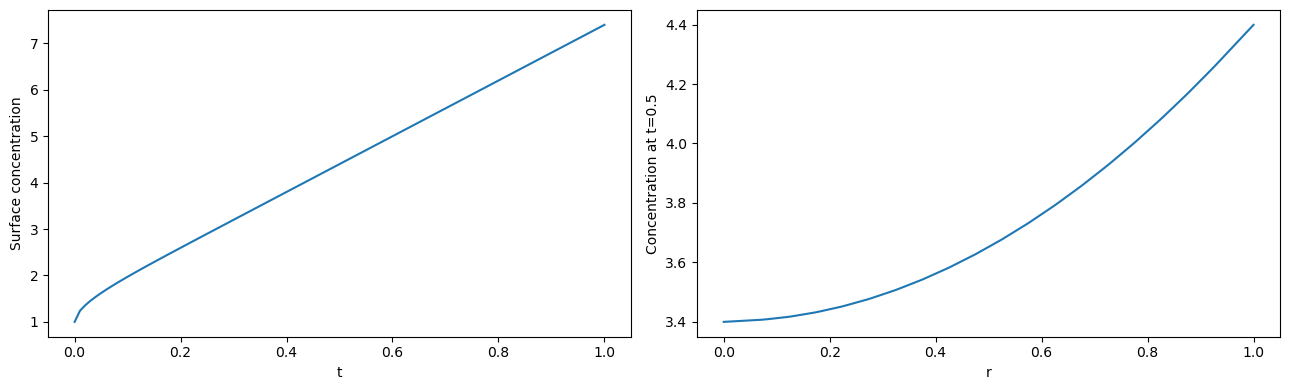

In [8]:
# Solving the model
import matplotlib.pyplot as plt
import numpy as np
# solve
solver = pb.ScipySolver()
t = np.linspace(0, 1, 100)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = solution["Concentration"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c(solution.t, r=1))
ax1.set_xlabel("t")
ax1.set_ylabel("Surface concentration")
r = np.linspace(0, 1, 100)
ax2.plot(r, c(t=0.5, r=r))
ax2.set_xlabel("r")
ax2.set_ylabel("Concentration at t=0.5")
plt.tight_layout()
plt.show()

Now it is time to solve a real-life battery problem! We consider the problem of spherical diffusion in the negative electrode particle within the single particle model. That is,
$$ \frac{\partial c}{\partial t} = \nabla \cdot (D \nabla c) $$

with the following boundary and initial conditions:
$$ \left.\frac{\partial c}{\partial r} \right \vert_{r=0} = 0, \;\; \left.\frac{\partial c}{\partial r} \right \vert_{r=R} = -\frac{j}{FD}, \;\; c \vert_{t=0}=c_0 $$

where:
- $c$ =is the concentration,
- $r$ = the radial coordinate, 
- $t$ = time, 
- $R$ = the particle radius ($10 \times 10^{-6}$ m)
- $D$ = the diffusion coefficient ($3.9 \times 10^{-14} \;m^2s^{-1}$)
- $j$ = the interfacial current density ($1.4 \;Am^{-2}$)
- $F$ = Faraday's constant ($96485 \;C mol^{-1}$)
- $c0$ = the initial concentration ($2.5 \times 10^4 \; mol \; m^{-3}$)

Create a model for this problem, discretise it and solve it. Use a uniform mesh with 20 points, and discretise the domain using the Finite Volume Method. Solve the model for 1 hour, and plot the surface concentration as a function of time, and the concentration as a function of radius at $t = 1000$ seconds.